# Predicting CPU Performance

We'll use a dataset to predict CPU performance ('PRP') with KNN and OLS regression models and compare those results.

Attribute Information:
    1. vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
    2. Model Name: many unique symbols
    3. MYCT: machine cycle time in nanoseconds (integer)
    4. MMIN: minimum main memory in kilobytes (integer)
    5. MMAX: maximum main memory in kilobytes (integer)
    6. CACH: cache memory in kilobytes (integer)
    7. CHMIN: minimum channels in units (integer)
    8. CHMAX: maximum channels in units (integer)
    9. PRP: published relative performance (integer)
    10. ERP: estimated relative performance from the original article (integer)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

%matplotlib inline
sns.set_style('white')

In [2]:
df_full = pd.read_csv('machine.data', 
                      names=['vendor','model','MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP','ERP']
                     ) 

In [3]:
df_full.head()

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [4]:
X = df_full.loc[:, 'MYCT':'CHMAX']
Y = df_full['PRP']

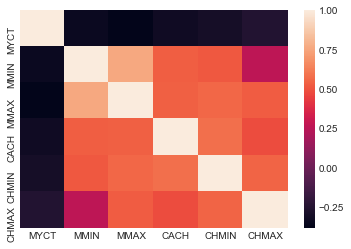

In [5]:
corrmat = df_full.loc[:, 'MYCT':'CHMAX'].corr()

sns.heatmap(corrmat)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


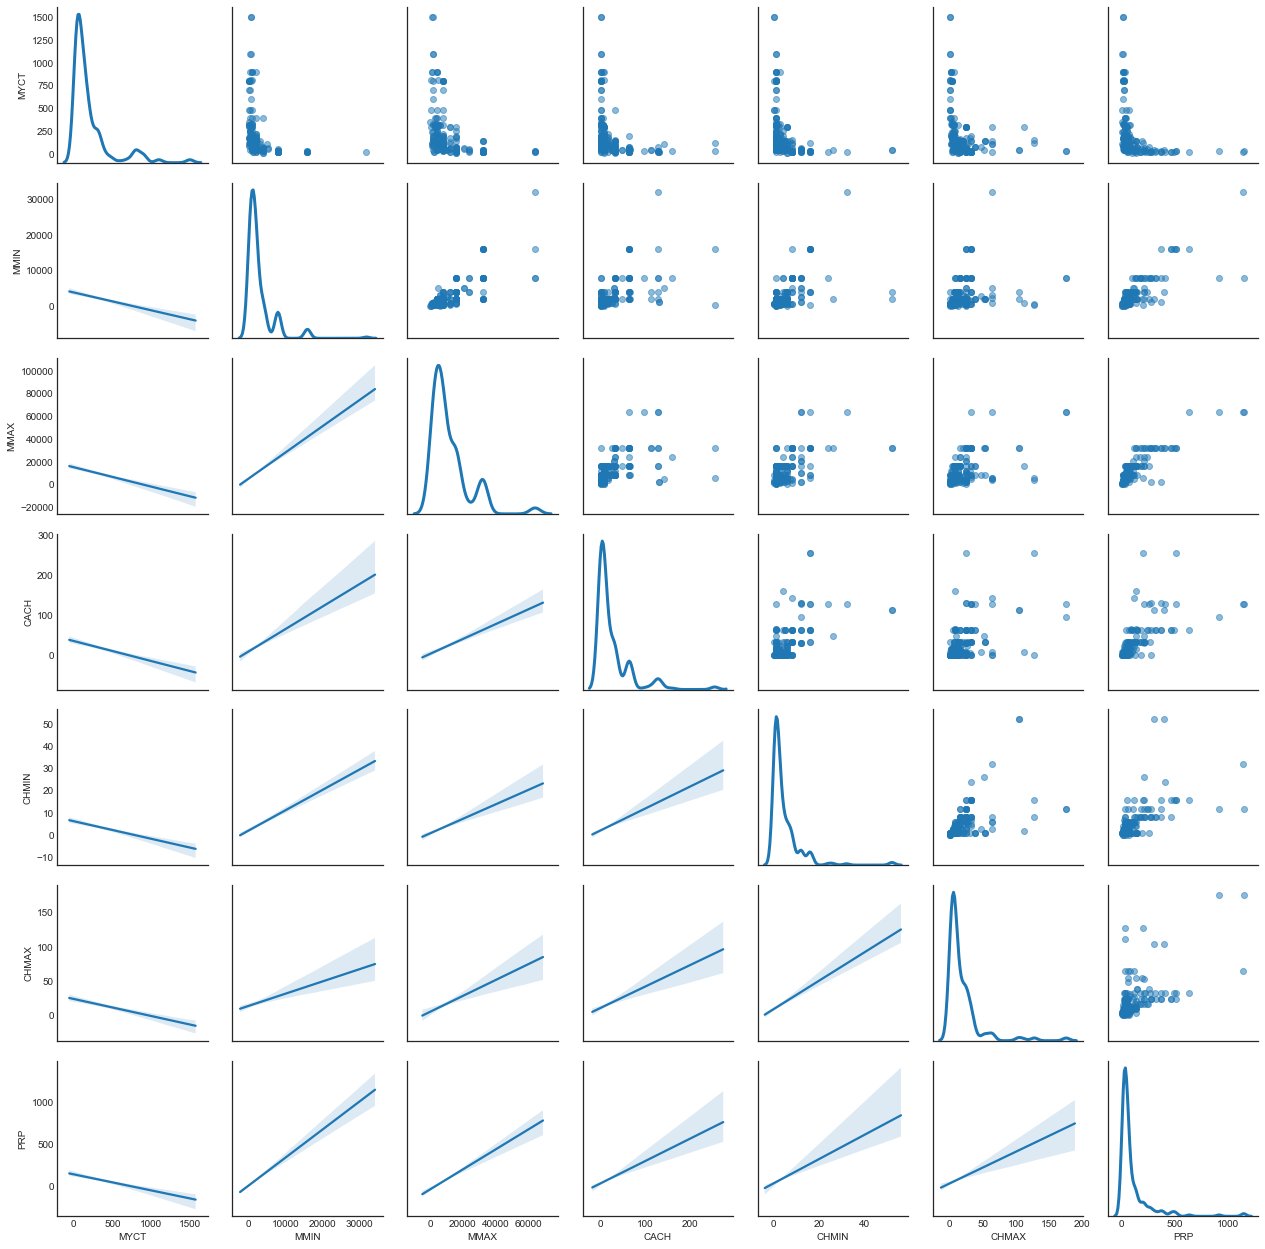

In [6]:
g = sns.PairGrid(df_full.loc[:,'MYCT':'PRP'], diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)

plt.show()

In [7]:
X = np.array(X)
Y = np.array(Y)

regr = LinearRegression()
neig = KNeighborsRegressor(n_neighbors=4)

regr.fit(X,Y)
neig.fit(X,Y)

print('Linear Regression Score: ' + str(regr.score(X,Y)))
print('KNN Regression Score: ' + str(neig.score(X,Y)))

n_folds = 4
score_regr = cross_val_score(regr, X, Y, cv=n_folds)
score_neig = cross_val_score(neig, X, Y, cv=n_folds)
print("Regr Accuracy: %0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2))
print("Neig Accuracy: %0.2f (+/- %0.2f)" % (score_neig.mean(), score_neig.std() * 2))

Linear Regression Score: 0.864890692277
KNN Regression Score: 0.92343743605
Regr Accuracy: 0.76 (+/- 0.22)
Neig Accuracy: 0.81 (+/- 0.15)


Let's engineer some features. The data skews right -- maybe we'll having some success taking the square root of some features. 

In [8]:
df_full.head()

,vendor,model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [9]:
df_eng = df_full[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']].copy()
df_eng['sqrtMYCT'] = np.sqrt(df_full['MYCT'])
df_eng['sqrtMMIN'] = np.sqrt(df_full['MMIN'])
df_eng['sqrtMMAX'] = np.sqrt(df_full['MMAX'])
df_eng['sqrtCACH'] = np.sqrt(df_full['CACH'])
df_eng['sqrtCHMIN'] = np.sqrt(df_full['CHMIN'])
df_eng['sqrtCHMAX'] = np.sqrt(df_full['CHMAX'])

df_eng['PRP'] = df_full['PRP']

In [10]:
df_eng.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,sqrtMYCT,sqrtMMIN,sqrtMMAX,sqrtCACH,sqrtCHMIN,sqrtCHMAX,PRP
0,125,256,6000,256,16,128,11.180340,16.000000,77.459667,16.000000,4.000000,11.313708,198
1,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,269
2,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,220
3,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,172
4,29,8000,16000,32,8,16,5.385165,89.442719,126.491106,5.656854,2.828427,4.000000,132


In [11]:
X_eng = df_eng.loc[:, 'MYCT':'sqrtCHMAX']
Y = df_eng['PRP']

X_eng = np.array(X_eng)
Y = np.array(Y)

regr = LinearRegression()
neig = KNeighborsRegressor(n_neighbors=3)

regr.fit(X_eng,Y)
neig.fit(X_eng,Y)

print('Linear Regression Score: ' + str(regr.score(X_eng,Y)))
print('KNN Regression Score: ' + str(neig.score(X_eng,Y)))

n_folds = 4
score_regr = cross_val_score(regr, X_eng, Y, cv=n_folds)
score_neig = cross_val_score(neig, X_eng, Y, cv=n_folds)
print("Regr Accuracy: %0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2))
print("Neig Accuracy: %0.2f (+/- %0.2f)" % (score_neig.mean(), score_neig.std() * 2))

Linear Regression Score: 0.916694111003
KNN Regression Score: 0.937202520146
Regr Accuracy: 0.80 (+/- 0.27)
Neig Accuracy: 0.83 (+/- 0.14)


These models seem to perform similarly, although KNN has lower variance in accuracy via cross validation. KNN seems to do better the fewer points we include. Let's look at that below.

In [12]:
for k in range(1, 16):
    neig = KNeighborsRegressor(n_neighbors=k)
    neig.fit(X_eng,Y)
    score_neig = cross_val_score(neig, X_eng, Y, cv=4)
    print("Neig Accuracy with k=%d: %0.2f (+/- %0.2f)" % (k, score_neig.mean(), score_neig.std() * 2))

Neig Accuracy with k=1: 0.84 (+/- 0.12)
Neig Accuracy with k=2: 0.85 (+/- 0.15)
Neig Accuracy with k=3: 0.83 (+/- 0.14)
Neig Accuracy with k=4: 0.81 (+/- 0.15)
Neig Accuracy with k=5: 0.78 (+/- 0.13)
Neig Accuracy with k=6: 0.76 (+/- 0.14)
Neig Accuracy with k=7: 0.74 (+/- 0.17)
Neig Accuracy with k=8: 0.73 (+/- 0.20)
Neig Accuracy with k=9: 0.72 (+/- 0.21)
Neig Accuracy with k=10: 0.70 (+/- 0.20)
Neig Accuracy with k=11: 0.68 (+/- 0.22)
Neig Accuracy with k=12: 0.67 (+/- 0.21)
Neig Accuracy with k=13: 0.65 (+/- 0.21)
Neig Accuracy with k=14: 0.65 (+/- 0.20)
Neig Accuracy with k=15: 0.65 (+/- 0.21)


These models with k=1 or k=2 are relatively quite good. They've got decently high accuracy, and a lot lower variance than the linear regression model. I suspect this may be because of the distribution of the data in the variables like MMIN and MMAX. 

In [13]:
df_eng['MMIN'].value_counts().sort_index()

64        1
96        1
128       1
192       1
256      13
262       2
384       2
500       1
512      22
524       1
768      10
1000     38
1310      2
1500      1
2000     54
2300      1
2620      2
3000      1
3100      2
4000     22
5000      1
5240      2
8000     20
16000     7
32000     1
Name: MMIN, dtype: int64

Most of the values are clumped into ranges that approximate powers of two. This data is far from linear, so a linear model will struggle. Perhaps we can engineer features that account for this to improve our regression.

In [14]:
df_eng2 = df_eng.copy()
df_eng2.pop('PRP')
df_eng2['logMYCT'] = np.log(df_eng['MYCT'])
df_eng2['logMMIN'] = np.log(df_eng['MMIN'])
df_eng2['logMMAX'] = np.log(df_eng['MMAX'])
df_eng2['PRP'] = df_eng['PRP']

In [15]:
df_eng2.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,sqrtMYCT,sqrtMMIN,sqrtMMAX,sqrtCACH,sqrtCHMIN,sqrtCHMAX,logMYCT,logMMIN,logMMAX,PRP
0,125,256,6000,256,16,128,11.180340,16.000000,77.459667,16.000000,4.000000,11.313708,4.828314,5.545177,8.699515,198
1,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,3.367296,8.987197,10.373491,269
2,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,3.367296,8.987197,10.373491,220
3,29,8000,32000,32,8,32,5.385165,89.442719,178.885438,5.656854,2.828427,5.656854,3.367296,8.987197,10.373491,172
4,29,8000,16000,32,8,16,5.385165,89.442719,126.491106,5.656854,2.828427,4.000000,3.367296,8.987197,9.680344,132


In [16]:
X_eng2 = df_eng2.loc[:, 'MYCT':'logMMAX']
Y = df_eng2['PRP']

X_eng2 = np.array(X_eng2)
Y = np.array(Y)

regr = LinearRegression()
neig = KNeighborsRegressor(n_neighbors=3)

regr.fit(X_eng2,Y)
neig.fit(X_eng2,Y)

print('Linear Regression Score: ' + str(regr.score(X_eng2,Y)))
print('KNN Regression Score: ' + str(neig.score(X_eng2,Y)))

n_folds = 4
score_regr = cross_val_score(regr, X_eng2, Y, cv=n_folds)
score_neig = cross_val_score(neig, X_eng2, Y, cv=n_folds)
print("Regr Accuracy: %0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2))
print("Neig Accuracy: %0.2f (+/- %0.2f)" % (score_neig.mean(), score_neig.std() * 2))

Linear Regression Score: 0.926801988641
KNN Regression Score: 0.937202520146
Regr Accuracy: 0.78 (+/- 0.19)
Neig Accuracy: 0.83 (+/- 0.14)


That's a bit better (variance in accuracy decreased from 0.27 to 0.19), but still not as good as KNN. For one final attempt, let's see what happens when we take the log of the output, PRP, as well. It's distribution is also highly skewed.

(array([  5.,  17.,  35.,  47.,  42.,  23.,  17.,  13.,   7.,   3.]),
 array([ 1.79175947,  2.31733524,  2.84291102,  3.36848679,  3.89406257,
         4.41963835,  4.94521412,  5.4707899 ,  5.99636567,  6.52194145,
         7.04751722]),
 <a list of 10 Patch objects>)

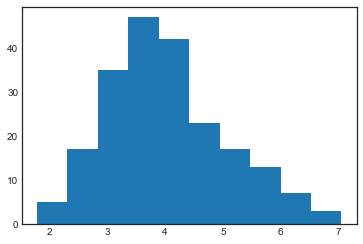

In [17]:
plt.hist(np.log(df_eng2['PRP']))

In [18]:
X_eng2 = df_eng2.loc[:, 'MYCT':'logMMAX']
Y_log = np.log(df_eng2['PRP'])

X_eng2 = np.array(X_eng2)
Y_log = np.array(Y_log)

regr = LinearRegression()
neig = KNeighborsRegressor(n_neighbors=3)

regr.fit(X_eng2,Y_log)
neig.fit(X_eng2,Y_log)

print('Linear Regression Score: ' + str(regr.score(X_eng2,Y_log)))
print('KNN Regression Score: ' + str(neig.score(X_eng2,Y_log)))

n_folds = 4
score_regr = cross_val_score(regr, X_eng2, Y_log, cv=n_folds)
score_neig = cross_val_score(neig, X_eng2, Y_log, cv=n_folds)
print("Regr Accuracy: %0.2f (+/- %0.2f)" % (score_regr.mean(), score_regr.std() * 2))
print("Neig Accuracy: %0.2f (+/- %0.2f)" % (score_neig.mean(), score_neig.std() * 2))

Linear Regression Score: 0.867656256447
KNN Regression Score: 0.883439597204
Regr Accuracy: 0.68 (+/- 0.15)
Neig Accuracy: 0.68 (+/- 0.29)


Well, that reduced the variance in accuracy for linear regression, but at the expense of the accuracy of the model. I think the take away here is that KNN is a better model for this dataset. I suspect this has to do with the grouping of data points in some of the important variables. It seems to matter more that we are "close" to a value like MMIN=4000, than we fit a regression line containing that variable. 